# DRILL: Prepare the Data

Prepare NYC crime data to model with multivariable regression according to these specification:

$$ Propertycrime=α+Population+Population2+Murder+Robbery $$

$$ Propertycrime=α+Population+Population2+Murder+Robbery $$

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.float_format = '{:,.0f}'.format

crime_df = pd.read_excel('./crimes/NY_crimes.xls', header=4)
crime_df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0,nan,0,0,0,12,2,10,0,0
1,Addison Town and Village,"2,577",3,0,nan,0,0,3,24,3,20,1,0
2,Akron Village,"2,846",3,0,nan,0,0,3,16,1,15,0,0
3,Albany,"97,956",791,8,nan,30,227,526,"4,090",705,"3,243",142,nan
4,Albion Village,"6,388",23,0,nan,3,4,16,223,53,165,5,nan


In [2]:
crime_df['Population Sq.'] = crime_df['Population'] ** 2
crime_df['Robbery Categ'] = np.where(crime_df['Robbery'] > 0, 1, 0)
crime_df['Murder Categ'] = np.where(crime_df['Murder and\nnonnegligent\nmanslaughter'] > 0, 1, 0)
crime_df.head(10)

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Population Sq.,Robbery Categ,Murder Categ
0,Adams Village,"1,861",0,0,nan,0,0,0,12,2,10,0,0,"3,463,321",0,0
1,Addison Town and Village,"2,577",3,0,nan,0,0,3,24,3,20,1,0,"6,640,929",0,0
2,Akron Village,"2,846",3,0,nan,0,0,3,16,1,15,0,0,"8,099,716",0,0
3,Albany,"97,956",791,8,nan,30,227,526,"4,090",705,"3,243",142,nan,"9,595,377,936",1,1
4,Albion Village,"6,388",23,0,nan,3,4,16,223,53,165,5,nan,"40,806,544",1,0
5,Alfred Village,"4,089",5,0,nan,0,3,2,46,10,36,0,nan,"16,719,921",1,0
6,Allegany Village,"1,781",3,0,nan,0,0,3,10,0,10,0,0,"3,171,961",0,0
7,Amherst Town,"118,296",107,1,nan,7,31,68,"2,118",204,"1,882",32,3,"13,993,943,616",1,1
8,Amityville Village,"9,519",9,0,nan,2,4,3,210,16,188,6,1,"90,611,361",1,0
9,Amsterdam,"18,182",30,0,nan,0,12,18,405,99,291,15,0,"330,585,124",1,0


Clean data as necessary. Do some graphing to see if there are any anomalous cases, and decide how you want to deal with them.

In [3]:
crime_df = crime_df.drop(['Rape\n(revised\ndefinition)1', 'Motor\nvehicle\ntheft', 'Larceny-\ntheft', 'Burglary', 'Property\ncrime', 'Arson3'], axis=1)
crime_df = crime_df[pd.notnull(crime_df['Population'])]
crime_df.rename(columns = {'Violent\ncrime': 'Violent crime', 'Murder and\nnonnegligent\nmanslaughter': 'Murder', 'Rape\n(legacy\ndefinition)2':'Rape', 'Aggravated\nassault': 'Assault'}, inplace = True)

crime_df['Violent crimes add up'] = crime_df['Violent crime'] == crime_df['Murder'] + crime_df['Rape'] + crime_df['Robbery'] +crime_df['Assault']
crime_df['More crimes than people'] = crime_df['Violent crime'] > crime_df['Population']

print('{} rows where violent crimes did not add up'.format(len(crime_df) - np.sum(crime_df['Violent crimes add up'])))
print('{} rows where more crimes than people'.format(np.sum(crime_df['More crimes than people'])))

crime_df = crime_df.drop(['Violent crimes add up', 'More crimes than people'], axis=1)
crime_df.head()

0 rows where violent crimes did not add up
0 rows where more crimes than people


,City,Population,Violent crime,Murder,Rape,Robbery,Assault,Population Sq.,Robbery Categ,Murder Categ
0,Adams Village,"1,861",0,0,0,0,0,"3,463,321",0,0
1,Addison Town and Village,"2,577",3,0,0,0,3,"6,640,929",0,0
2,Akron Village,"2,846",3,0,0,0,3,"8,099,716",0,0
3,Albany,"97,956",791,8,30,227,526,"9,595,377,936",1,1
4,Albion Village,"6,388",23,0,3,4,16,"40,806,544",1,0


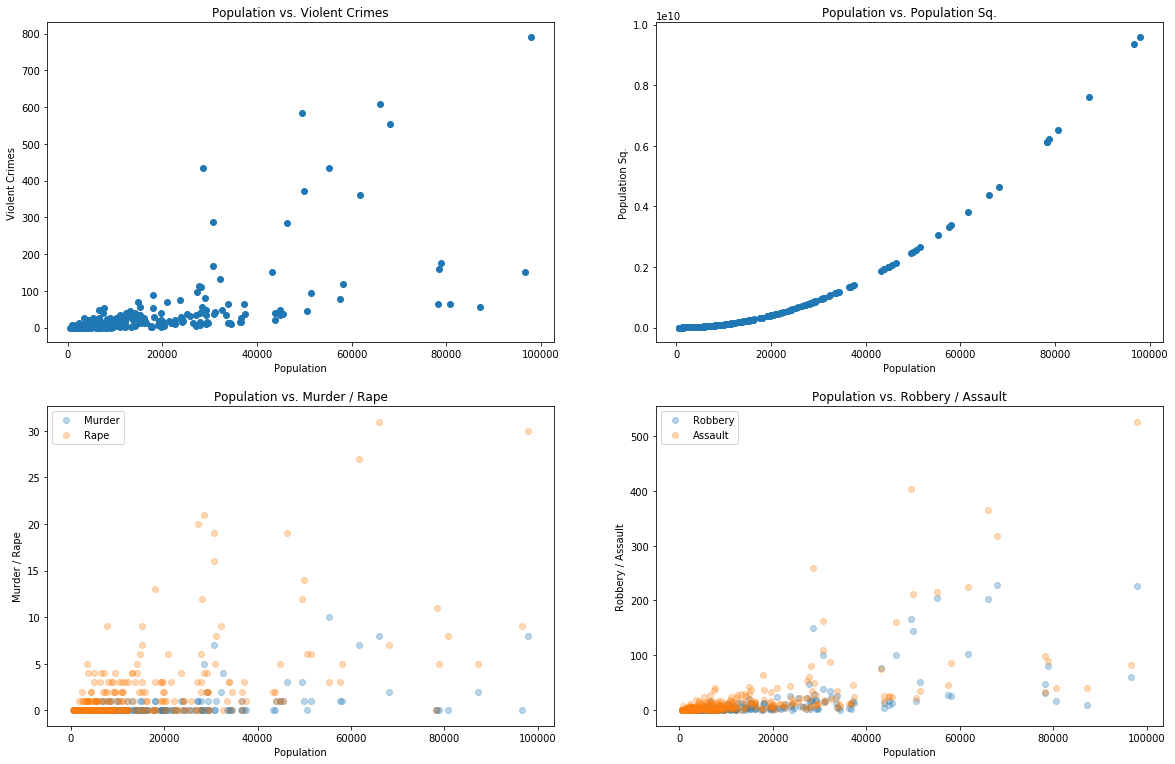

In [4]:
cities_under_outlier_cutoff = crime_df[crime_df['Population'] < 100000]

def display_relevant_plots(df):
    plt.figure(figsize=(20,20))

    plt.subplot(3, 2, 1)
    plt.scatter(df['Population'], df['Violent crime'])
    plt.xlabel('Population')
    plt.ylabel('Violent Crimes')
    plt.title('Population vs. Violent Crimes')

    plt.subplot(3, 2, 2)
    plt.scatter(df['Population'], df['Population Sq.'])
    plt.xlabel('Population')
    plt.ylabel('Population Sq.')
    plt.title('Population vs. Population Sq.')

    plt.subplot(3, 2, 3)
    plt.scatter(df['Population'], df['Murder'], alpha=0.3)
    plt.scatter(df['Population'], df['Rape'], alpha=0.3)
    plt.xlabel('Population')
    plt.ylabel('Murder / Rape')
    plt.title('Population vs. Murder / Rape')
    plt.legend(['Murder', 'Rape'])

    plt.subplot(3, 2, 4)
    plt.scatter(df['Population'], df['Robbery'], alpha=0.3)
    plt.scatter(df['Population'], df['Assault'], alpha=0.3)
    plt.xlabel('Population')
    plt.ylabel('Robbery / Assault')
    plt.title('Population vs. Robbery / Assault')
    plt.legend(['Robbery', 'Assault'])

    plt.show()

display_relevant_plots(cities_under_outlier_cutoff)

Getting rid of rows where there are 0 violent crime, murder, rape, robbery, or assault will get rid of graphs where there are 0s across cities of wildly varying populations.

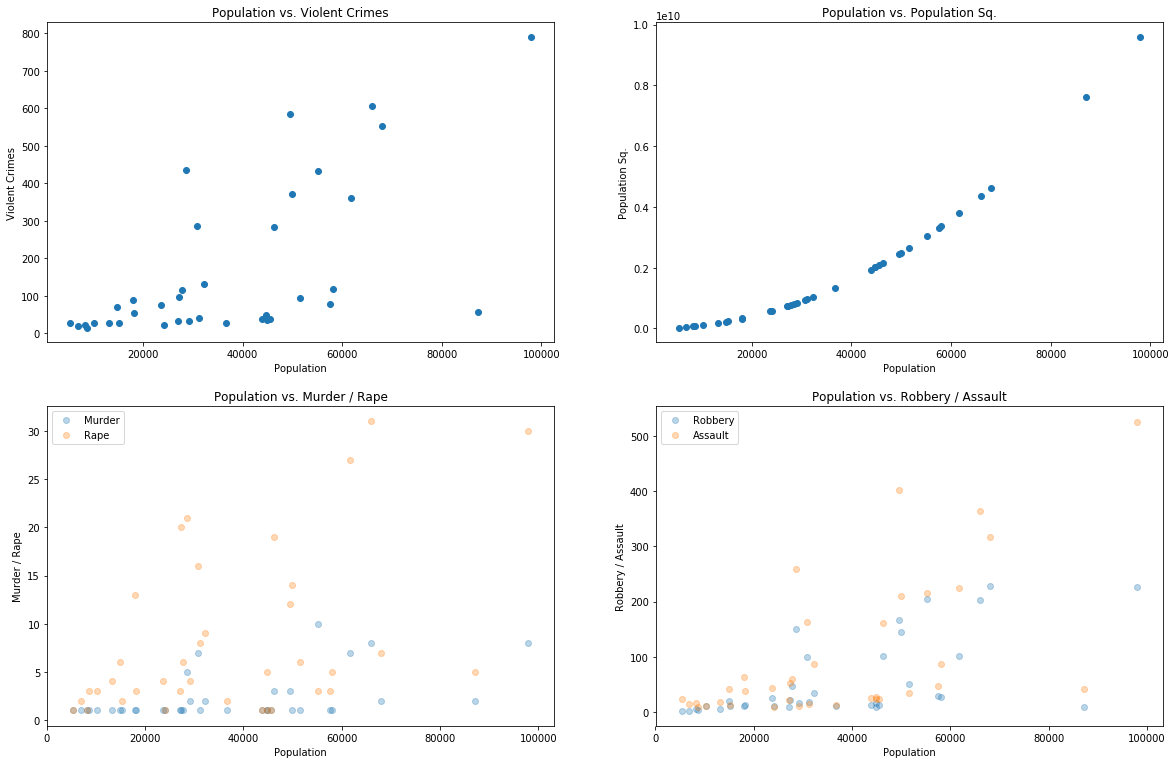

In [8]:
crime_df = crime_df[(crime_df['Violent crime'] > 0) & (crime_df['Murder'] > 0) & (crime_df['Rape'] > 0) & (crime_df['Robbery'] > 0) & (crime_df['Assault'] > 0)]
new_cities_under_outlier_cutoff = crime_df[crime_df['Population'] < 100000]

display_relevant_plots(new_cities_under_outlier_cutoff)